<a href="https://colab.research.google.com/github/oransom48/CassavaDiseaseAI/blob/main/cassavamodelv2_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#batch size
bs=32

#epoch
epo=50

#learning rate
lr=0.0001

# Install Kaggle & Mount Drive

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c cassava-disease
#kaggle competitions download -c [COMPETITION]

  0% 0.00/645k [00:00<?, ?B/s]
100% 645k/645k [00:00<00:00, 41.2MB/s]
  0% 0.00/83.8k [00:00<?, ?B/s]
100% 83.8k/83.8k [00:00<00:00, 76.0MB/s]
 99% 512M/515M [00:05<00:00, 123MB/s]
100% 515M/515M [00:05<00:00, 102MB/s]
 99% 767M/777M [00:07<00:00, 103MB/s] 
100% 777M/777M [00:07<00:00, 106MB/s]
 99% 1.03G/1.04G [00:15<00:00, 82.7MB/s]
100% 1.04G/1.04G [00:15<00:00, 73.8MB/s]


In [ ]:
! unzip train.zip
! unzip test.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: train/cbsd/train-cbsd-685.jpg  
  inflating: train/cbsd/train-cbsd-74.jpg  
  inflating: train/cbsd/train-cbsd-875.jpg  
  inflating: train/cbsd/train-cbsd-861.jpg  
  inflating: train/cbsd/train-cbsd-60.jpg  
  inflating: train/cbsd/train-cbsd-1165.jpg  
  inflating: train/cbsd/train-cbsd-134.jpg  
  inflating: train/cbsd/train-cbsd-652.jpg  
  inflating: train/cbsd/train-cbsd-646.jpg  
  inflating: train/cbsd/train-cbsd-120.jpg  
  inflating: train/cbsd/train-cbsd-1171.jpg  
  inflating: train/cbsd/train-cbsd-108.jpg  
  inflating: train/cbsd/train-cbsd-1159.jpg  
  inflating: train/cbsd/train-cbsd-1158.jpg  
  inflating: train/cbsd/train-cbsd-109.jpg  
  inflating: train/cbsd/train-cbsd-647.jpg  
  inflating: train/cbsd/train-cbsd-1170.jpg  
  inflating: train/cbsd/train-cbsd-121.jpg  
  inflating: train/cbsd/train-cbsd-135.jpg  
  inflating: train/cbsd/train-cbsd-1164.jpg  
  inflating: train/cbsd/train-cbsd-653.

In [ ]:
import os

In [ ]:
pip install split-folders

In [ ]:
pip install imgaug

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tensorflow import keras

from keras.applications import mobilenet_v2
#from keras.applications import mobilenet_v2
#from keras.applications import mobilenet_v3

from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D #ดึงเฉพาะค่าเฉลี่ย

import tensorflow as tf

from sklearn.metrics import classification_report

# **Split Folder**

In [ ]:
import splitfolders
splitfolders.ratio("/content/train", output="output", seed=1337, ratio=(.7, .2, .1))

Copying files: 5656 files [00:03, 1856.34 files/s]


train validate test split
https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

# use imgaug to preprocess the data

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
import cv2
import glob
from keras.preprocessing.image import ImageDataGenerator

seq = iaa.Sequential([
                      iaa.Resize({"height": 224, "width": 224}),
                      iaa.Sometimes(0.5,[
                                    iaa.OneOf([
                                                 iaa.GaussianBlur(sigma=(0, 2.0)),
                                                 iaa.AverageBlur(k=(1, 5)),
                                                 iaa.MotionBlur(k=(3, 7), angle=(0,360)),
                                                 iaa.Multiply(mul=(0.5, 1.5))
                                    ])
                      ]),
                      iaa.Sometimes(0.25,[
                                    iaa.Affine(rotate=(-45, 45))
                      ])
          ])

def augment(img):
    #images_aug = seq(images=img)
    aug_image = seq.augment_image(img)
    #return images_aug
    return aug_image

train_datagen=ImageDataGenerator(rescale=1./255, preprocessing_function = augment )
test_datagen=ImageDataGenerator(rescale=1./255)

training_data = train_datagen.flow_from_directory("/content/output/train",
                                                                            target_size=(224,224),
                                                                            batch_size=bs,
                                                                            class_mode="categorical")
validate_data = test_datagen.flow_from_directory("/content/output/val",
                                                                            target_size=(224,224),
                                                                            batch_size=bs,
                                                                            class_mode="categorical")
test_data = test_datagen.flow_from_directory("/content/output/test",
                                                                            target_size=(224,224),
                                                                            batch_size=bs,
                                                                            class_mode="categorical")
#https://pretagteam.com/question/keras-imagedatagenerator-imgaug

Found 3958 images belonging to 5 classes.
Found 1129 images belonging to 5 classes.
Found 569 images belonging to 5 classes.


#Create model

In [ ]:
import tensorflow as tf
base_model=tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
base_model.trainable = False
#https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(512, activation='relu')(x)
x=Dropout(0.5)(x)
preds=Dense(5, activation='softmax')(x)

In [ ]:
model=Model(inputs=base_model.input, outputs=preds)

In [ ]:
adam=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
#https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

#model & dataset overview

In [ ]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

Original:


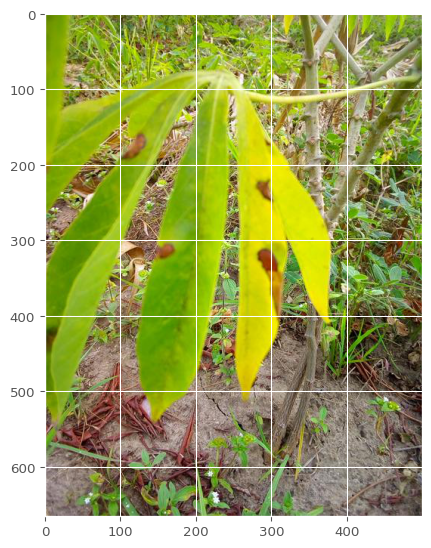

Augmented:


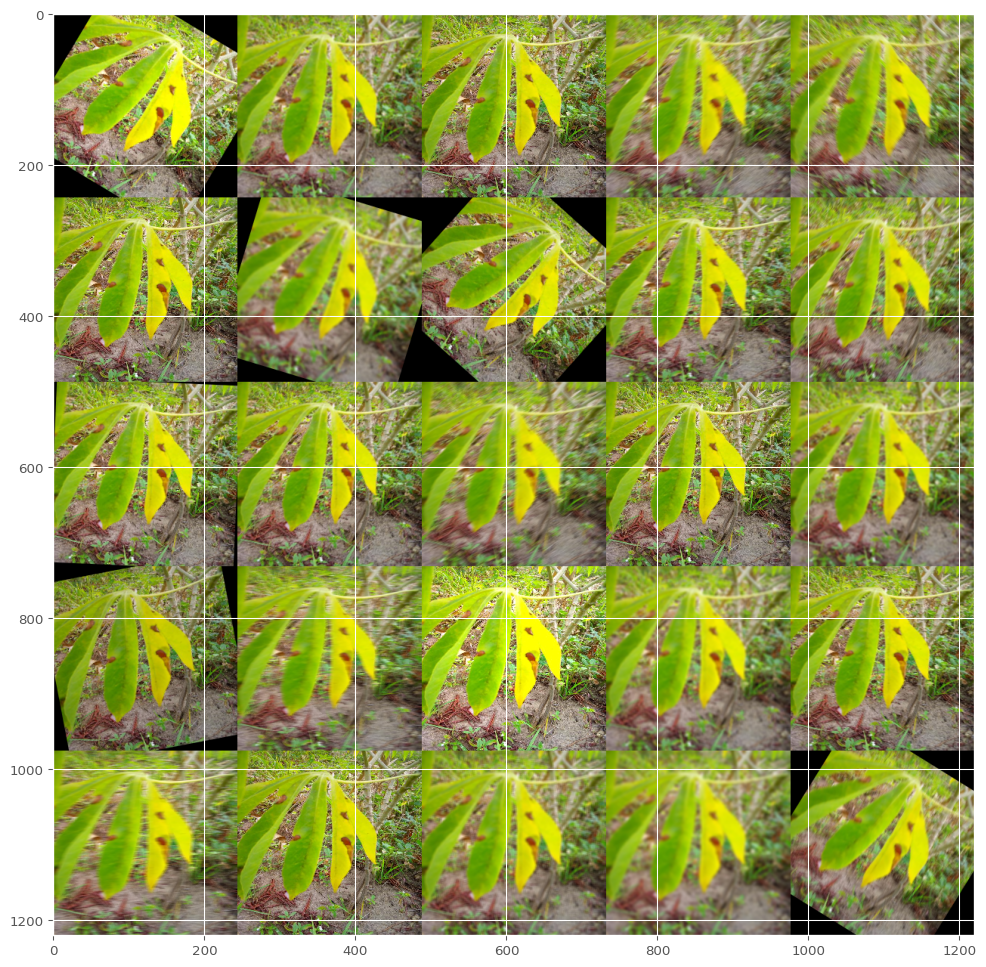

<Figure size 432x288 with 0 Axes>

In [ ]:
import imageio
import imgaug as ia
%matplotlib inline

image = imageio.imread("/content/output/test/cbb/train-cbb-106.jpg")

print("Original:")
ia.imshow(image)

import imgaug.augmenters as iaa

aug = iaa.Sequential([
                      iaa.Resize({"height": 244, "width": 244}),
                      iaa.OneOf([
                                    iaa.GaussianBlur(sigma=(0, 2.0)),
                                    iaa.AverageBlur(k=(1, 5)),
                                    iaa.MotionBlur(k=(3, 7), angle=(0,360)),
                                    iaa.Multiply(mul=(0.5, 1.5))
                      ]),
                      iaa.Sometimes(0.25,[
                                    iaa.Affine(rotate=(-45, 45))
                      ])
          ])
images_aug = [aug(image=image) for _ in range(25)]

print("Augmented:")
ia.imshow(ia.draw_grid(images_aug, cols=5, rows=5))

plt.savefig("aug_example.png")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import numpy as np
from keras.preprocessing import image

def grid_iterator(n_rows, n_cols, axis_size=2.5, total=None, fig_title=None ):
  fig=plt.figure()
  gs=gridspec.GridSpec(n_rows, n_cols, top=1., bottom=0., right=1., left=0., hspace=0.15, wspace=0.1)

  index=0
  for r in range (n_rows):
    for c in range (n_cols):
      ax=fig.add_subplot(gs[r, c])
      yield index, ax
      index += 1
      if total and index >= total:
        break

    width, height=n_cols * axis_size, n_rows * axis_size
    fig.set_size_inches(width, height)
'''
    if fig.title is not None:
      fig.subtitle(fig_title, fontsize=16, y=1.05)
'''
for i, ax in grid_iterator(n_rows=10, n_cols=4, axis_size=4, total=test_data.samples):
  image_path='/content/output/train'+"/"+training_data.filenames[i]
  test_image=image.load_img(image_path, target_size=(224,224))
  test_image=image.img_to_array(test_image)
  test_image=test_image/255.0
  test_image=np.expand_dims(test_image, axis=0)
  title=test_data.filenames[i]
  title=title.split('/')
  img=Image.open(image_path)
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect('auto')
  ax.set_title(title[0])

#train model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
H = model.fit(training_data,
          epochs = epo,
          steps_per_epoch = (training_data.n // training_data.batch_size),
          validation_data=validate_data,
          validation_steps= (validate_data.n // validate_data.batch_size))

Epoch 1/50
123/123 [==============================] - 68s 522ms/step - loss: 1.3861 - accuracy: 0.4722 - val_loss: 0.9916 - val_accuracy: 0.6277
Epoch 2/50
123/123 [==============================] - 63s 514ms/step - loss: 1.1110 - accuracy: 0.5838 - val_loss: 0.9151 - val_accuracy: 0.6696
Epoch 3/50
123/123 [==============================] - 64s 520ms/step - loss: 1.0204 - accuracy: 0.6070 - val_loss: 0.8661 - val_accuracy: 0.6759
Epoch 4/50
123/123 [==============================] - 63s 516ms/step - loss: 0.9368 - accuracy: 0.6353 - val_loss: 0.8273 - val_accuracy: 0.6982
Epoch 5/50
123/123 [==============================] - 63s 514ms/step - loss: 0.9193 - accuracy: 0.6538 - val_loss: 0.8095 - val_accuracy: 0.7125
Epoch 6/50
123/123 [==============================] - 64s 518ms/step - loss: 0.9031 - accuracy: 0.6503 - val_loss: 0.7936 - val_accuracy: 0.7134
Epoch 7/50
123/123 [==============================] - 64s 520ms/step - loss: 0.8694 - accuracy: 0.6691 - val_loss: 0.8110 - val_ac

https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras
https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

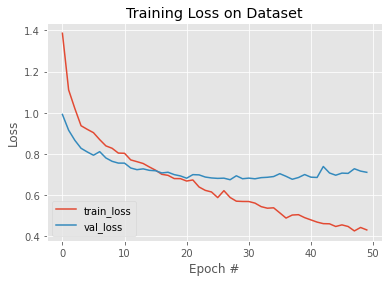

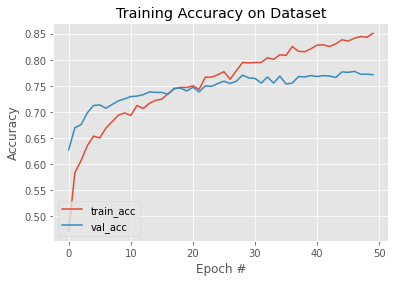

In [ ]:
N = epo
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot2.png")

#Classification Report

In [ ]:
#set target_size
predicted_classes = []
for index in range(test_data.samples):
  image_path = '/content/output/test' + "/" + test_data.filenames[index]
  test_image = image.load_img(image_path, target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = test_image / 255.0
  test_image = np.expand_dims(test_image, axis = 0)
  result = model.predict(test_image)
  #training_set.class_indices
  predicted_classes.append(np.argmax(result))

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         cbb       0.61      0.40      0.49        47
        cbsd       0.78      0.72      0.75       145
         cgm       0.74      0.55      0.63        78
         cmd       0.81      0.94      0.87       267
     healthy       0.66      0.72      0.69        32

    accuracy                           0.78       569
   macro avg       0.72      0.67      0.69       569
weighted avg       0.77      0.78      0.77       569



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print(confusion_matrix(true_classes, predicted_classes))
print(metrics.accuracy_score(true_classes, predicted_classes))
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix

[[ 19  16   4   7   1]
 [  8 105   4  24   4]
 [  2   3  43  24   6]
 [  0   8   6 252   1]
 [  2   3   1   3  23]]
0.7768014059753954


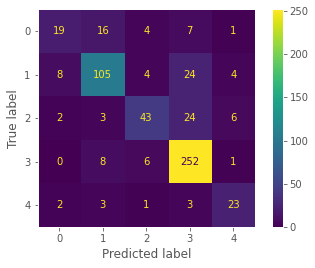

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(None)
plt.show()
plt.savefig("confusemetrix.png")
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay

#Save model

In [ ]:
#วิธีตั้งชื่อไฟล์ => "cassava_" + transfered_model + "_" + (accuracy*10000)
#ex. transfered_model = "mobilenetv2", accuracy = 0.9999
#     model_name        =  cassava_mobilenetv2_9999

model_name='cassava_mobilenetv2_7768.h5'
model_path=os.path.join('/content/drive/MyDrive/model', model_name)
model.save(model_path)
print("Save trained model at %s " % model_path)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Save trained model at /content/drive/MyDrive/model/cassava_mobilenetv2_7768.h5 


#Import Model (optional)

In [ ]:
model= tf.keras.models.load_model('/content/drive/MyDrive/model/cassava_mobilenetv2_9287.h5')

# **Import photo & guess**

In [ ]:
image_path = '/content/test/0/test-img-5.jpg'

test_image = image.load_img(image_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = test_image / 255.0
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#training_set.class_indices
answer = np.argmax(result)
if answer==0:
  print("cbb")
if answer==1:
  print("cbsd")
if answer==2:
  print("cgm")
if answer==3:
  print("cmd")
if answer==4:
  print("healthy")

cgm


# **LIME**

In [ ]:
import skimage

In [ ]:
! pip install lime

     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=23c2b92a24882370e09fe9b53152db76819f52fe6dc45db224598edd78f7470c
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [ ]:
image_path = '/content/output/test/cmd/train-cmd-140.jpg'

test_image = image.load_img(image_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = test_image / 255.0
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#training_set.class_indices
answer = np.argmax(result)
pct = np.max(result)
if answer==0:
  print("cbb")
if answer==1:
  print("cbsd")
if answer==2:
  print("cgm")
if answer==3:
  print("cmd")
if answer==4:
  print("healthy")

print(pct)

cmd
0.97848254


In [ ]:
explaination = explainer.explain_instance(test_image[0].astype('double'), model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 223.5, 223.5, -0.5)

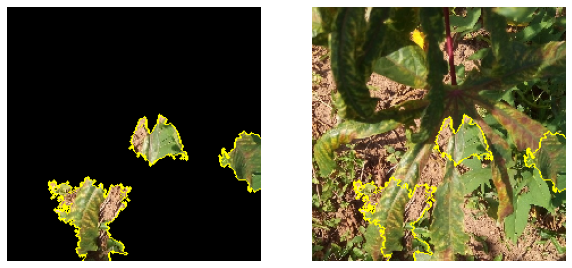

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explaination.get_image_and_mask(explaination.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
temp_2, mask_2 = explaination.get_image_and_mask(explaination.top_labels[0], positive_only=True, num_features=3, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')